# EDA

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# matplotlib のフォント設定を変更
plt.rcParams['font.family'] = 'sans-serif'

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist

## データセット読み込み

In [ ]:
# 入力：読み込みたい記述子のタイプを選択
descriptor_type = 'mordred_3d'  # 'rdkit' or 'mordred_2d' or 'mordred_3d'

# ベースのデータ
dataset = pd.read_csv('data/material_data.csv', index_col=0)

# 条件に応じて記述子ファイルを読み込む
if descriptor_type == "rdkit":
    des = pd.read_csv("outputs/descriptors/descriptor_rdkit.csv", index_col=0)
elif descriptor_type == "mordred_2d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_2d.csv", index_col=0)
elif descriptor_type == "mordred_3d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_3d.csv", index_col=0)
else:
    raise ValueError(f"未知のdescriptor_type: {descriptor_type}")

# 結合
dataset_full = pd.concat([dataset.reset_index(), des.reset_index(drop=True)], axis=1)
dataset_full = dataset_full.set_index('Material')

# 確認
print(dataset.shape, des.shape, dataset_full.shape)


(1258, 3) (1258, 1480) (1258, 1483)


In [75]:
dataset_full.head()

,SMILES,Type,PL,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
Material,,,,,,,,,,,,,,,,,,,,,
BTD1,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=CC=...,BTD,533.0,0,0,52.858928,2.605019,5.075721,52.858928,1.355357,...,11.063085,95.162927,520.197320,7.764139,4998,81,238.0,303.0,10.430556,7.972222
BTD2,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,0,0,106.389455,2.619063,5.089934,106.389455,1.381681,...,11.699944,138.030334,1002.375619,7.892721,36855,161,470.0,597.0,17.708333,15.861111
BTD3,CC1(C)C2=C(C=CC(C3=CC(N4C(C=CC=C5)=C5C6=C4C=CC...,BTD,538.0,0,0,106.360771,2.616201,5.087066,106.360771,1.381309,...,11.699281,138.029670,1002.375619,7.892721,36739,161,470.0,597.0,17.708333,15.861111
BTD4,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(N...,BTD,584.0,0,0,88.539924,2.617273,5.088287,88.539924,1.362153,...,11.443500,123.348096,854.344318,7.696796,21841,129,382.0,477.0,15.819444,13.638889
BTD5,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,0,0,106.409272,2.620668,5.091786,106.409272,1.381939,...,11.713783,138.055708,1002.375619,7.892721,35231,163,470.0,599.0,17.708333,15.916667


In [76]:
# PLに欠損値が入っている行を消して、学習データのみにする
dataset_train = dataset_full.dropna(subset='PL')
# SMILESとTypeも消しておく
dataset_train = dataset_train.drop(['SMILES', 'Type'], axis=1)

dataset_train.shape

(251, 1481)

In [77]:
# infをNaNに置き換え
dataset_train = dataset_train.replace(np.inf, np.nan).fillna(np.nan)
dataset_train = dataset_train.drop(dataset_train.columns[dataset_train.isnull().any()], axis=1)

# 学習データのstdが0の列を特定
zero_std_cols = dataset_train.columns[dataset_train.std() == 0]

# 学習・未知データから同じ列を削除
dataset_train = dataset_train.drop(columns=zero_std_cols)

dataset_train.shape

(251, 1220)

In [78]:
# 共通インデックスを使ってTypeを結合
dataset_train_with_type = pd.concat([dataset_full['Type'].reset_index(drop=True), dataset_train.reset_index(drop=False)], axis=1)


## データ可視化

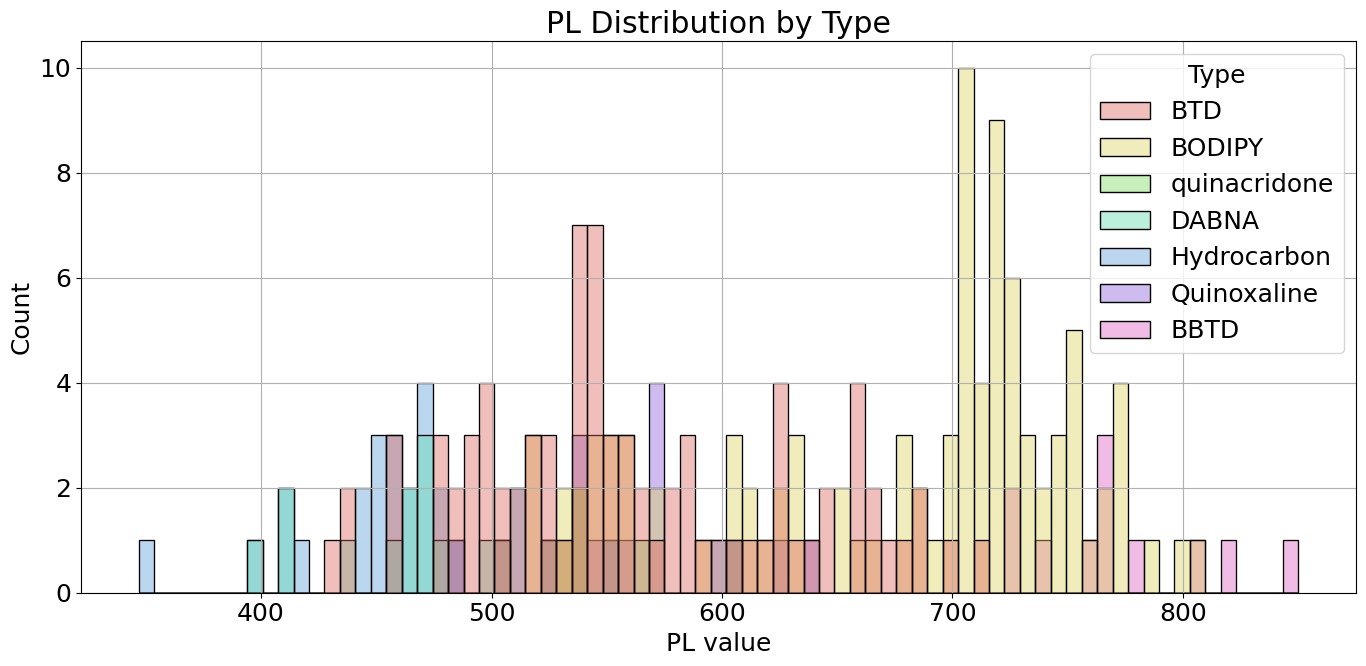

In [79]:
# ヒストグラムを描画してそのオブジェクトを plot に代入
plt.figure(figsize=(14, 7))
sns.histplot(data=dataset_train_with_type,
                  x='PL',
                  hue='Type',
                  palette='hls',
                  bins=75,
                  alpha=0.4,
                  legend=True)  # 凡例を明示的に有効化

plt.xlabel('PL value')
plt.ylabel('Count')
plt.title('PL Distribution by Type')
plt.grid(True)
plt.tight_layout()
plt.show()

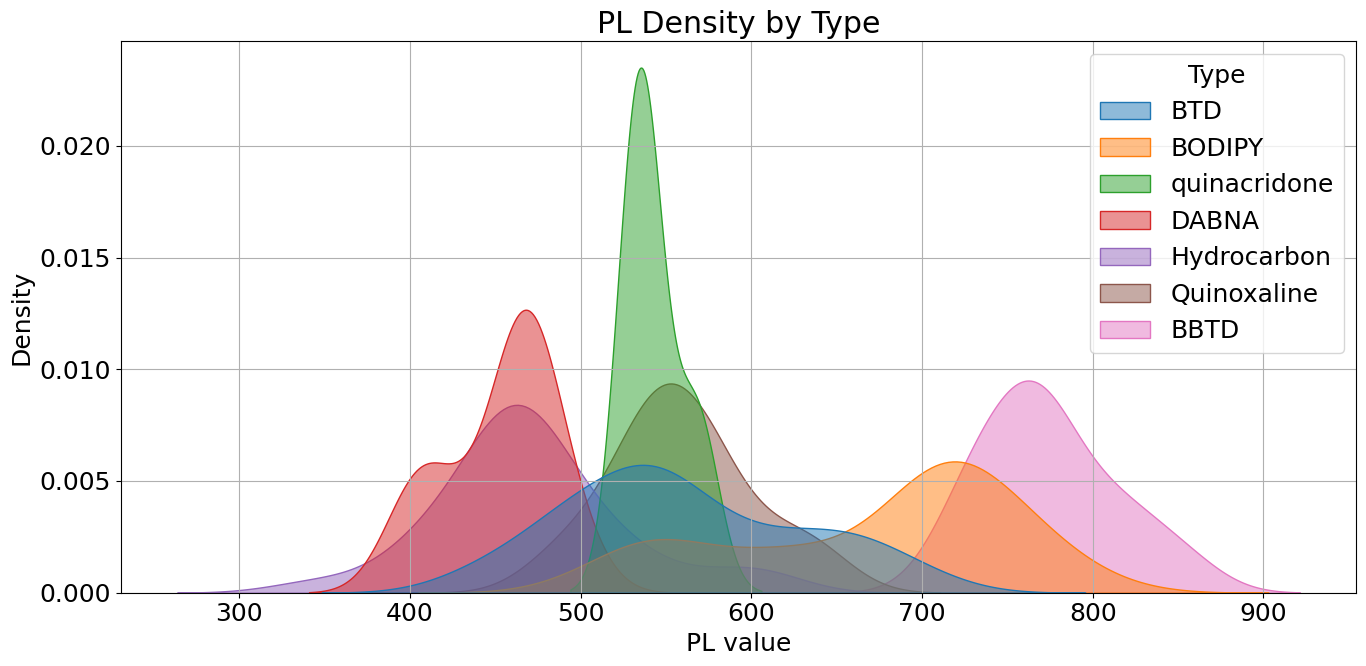

In [80]:
# Typeごとのkde plot
plt.figure(figsize=(14, 7))
sns.kdeplot(data=dataset_train_with_type,
            x="PL",
            hue="Type",
            fill=True,
            common_norm=False,
            alpha=0.5)

plt.xlabel('PL value')
plt.ylabel('Density')
plt.title('PL Density by Type')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3476/3632092237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type',


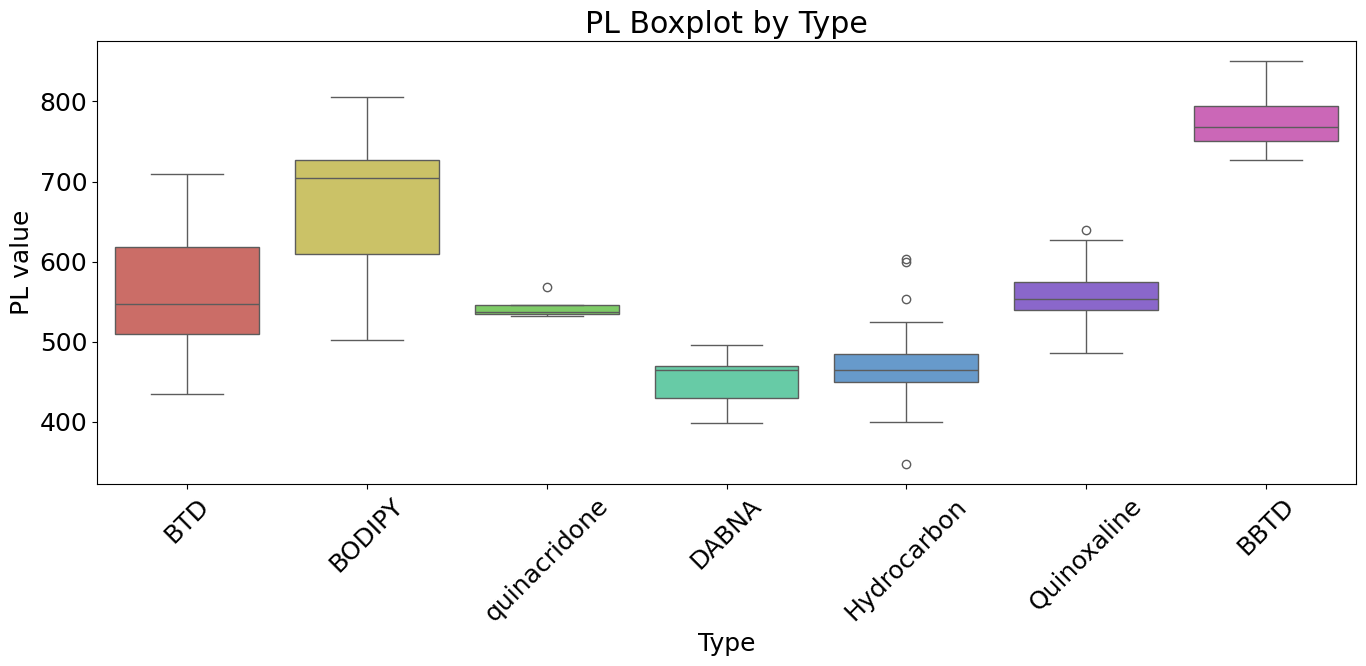

In [81]:
# 箱ひげ
plt.figure(figsize=(14, 7))
sns.boxplot(x='Type',
            y='PL',
            palette='hls',
            data=dataset_train_with_type)

plt.xlabel('Type')
plt.ylabel('PL value')
plt.title('PL Boxplot by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

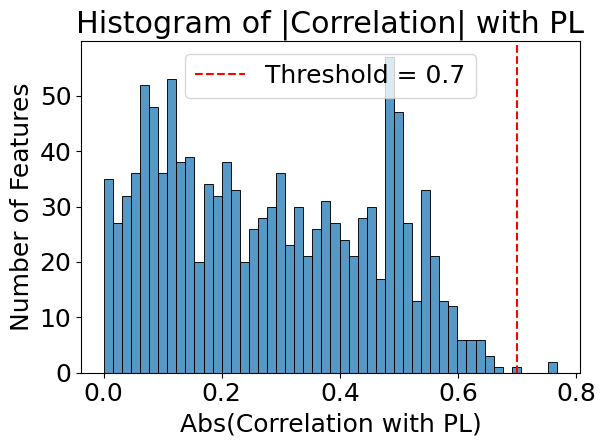

In [82]:
# 相関係数の計算
corr_coef = dataset_train.corr()

# 相関係数の絶対値（PL自身との相関を除く）
pl_corr_abs = corr_coef['PL'].drop('PL').abs()

# ヒストグラム描画
sns.histplot(pl_corr_abs, bins=50)

plt.xlabel('Abs(Correlation with PL)')
plt.ylabel('Number of Features')
plt.title('Histogram of |Correlation| with PL')
plt.axvline(x=0.7, color='red', linestyle='--', label='Threshold = 0.7')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# PLとの相関が±0.7以上の説明変数を抽出
abs_07 = pl_corr_abs[pl_corr_abs.abs() >= 0.7].sort_values(ascending=False)

# 結果を表示
print(abs_07)


MID_h      0.767951
nHetero    0.759882
Name: PL, dtype: float64


## PCA
学習データのみで実施する

In [84]:
# 目的変数
y = dataset_train['PL']
# 説明変数（標準偏差が０のものを除いたもの）
X = dataset_train.drop('PL', axis=1)

y.shape, X.shape

((251,), (251, 1219))

In [85]:
# オートスケーリング
autoscaled_X = (X - X.mean()) / X.std()

In [86]:
# PCA
pca = PCA()
pca.fit(autoscaled_X)

# loading、各説明変数がその主成分に対してどれだけ寄与しているか
loading = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# score、変換後の座標
score = pd.DataFrame(pca.transform(autoscaled_X), index=X.index, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# 寄与率
cont_ratio = pd.DataFrame(pca.explained_variance_ratio_)
# 累積寄与率
cum_cont_ratio = cont_ratio.cumsum()
# 結合
cont_cumcont_ratio = pd.concat([cont_ratio, cum_cont_ratio], axis=1)
cont_cumcont_ratio.columns = ['contribution_ratio', 'cumulative_contribution_ratio']
cont_cumcont_ratio.index = [f'PC{i+1}' for i in cont_cumcont_ratio.index]

cont_cumcont_ratio.head(20)

,contribution_ratio,cumulative_contribution_ratio
PC1,0.328067,0.328067
PC2,0.108347,0.436414
PC3,0.085250,0.521665
PC4,0.072126,0.593791
PC5,0.046398,0.640189
PC6,0.034952,0.675140
PC7,0.029942,0.705082
PC8,0.021128,0.726210
PC9,0.018196,0.744406
PC10,0.017320,0.761726


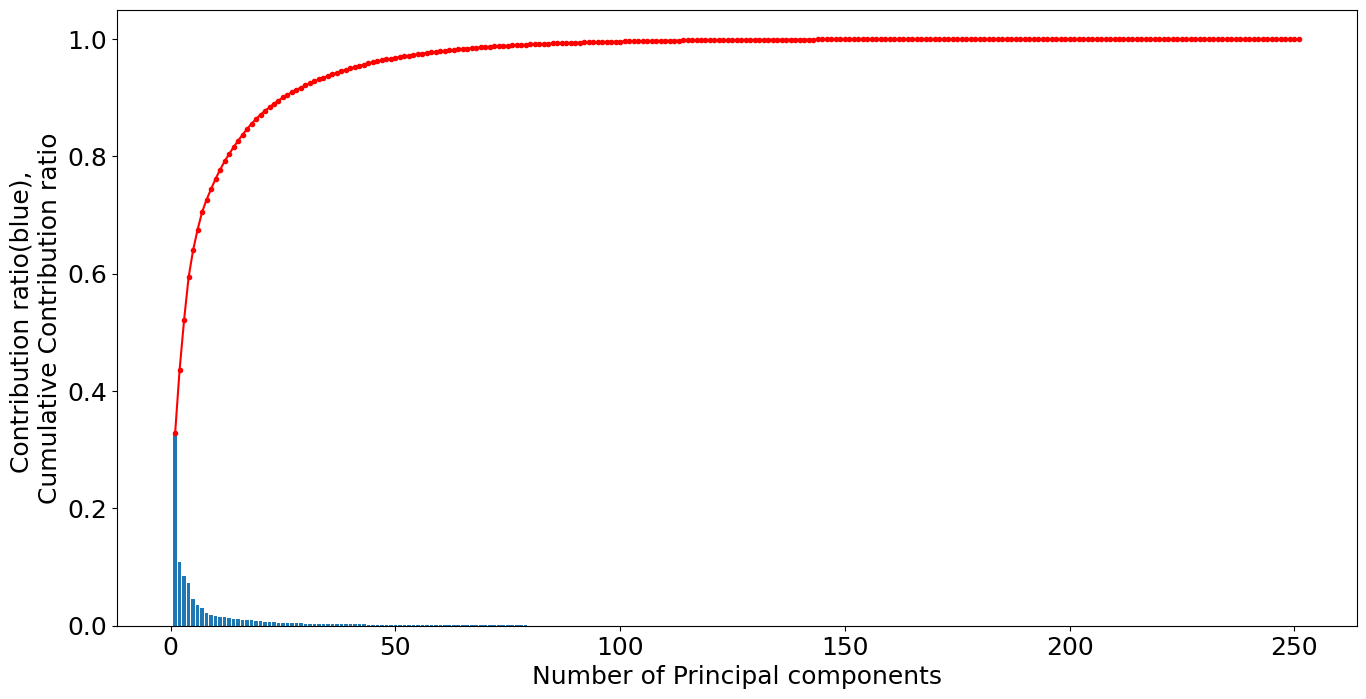

In [87]:
# 寄与率を折れ線で、累積寄与率を棒で可視化
x_axis = range(1, cont_cumcont_ratio.shape[0]+1)

# 図のサイズ
plt.figure(figsize=(16, 8))

# 棒グラフ
plt.bar(x_axis, cont_cumcont_ratio.iloc[:, 0], align='center')
# 折れ線
plt.plot(x_axis, cont_cumcont_ratio.iloc[:, 1], 'r.-')

plt.xlabel('Number of Principal components')
plt.ylabel('Contribution ratio(blue), \nCumulative Contribution ratio')

plt.show()

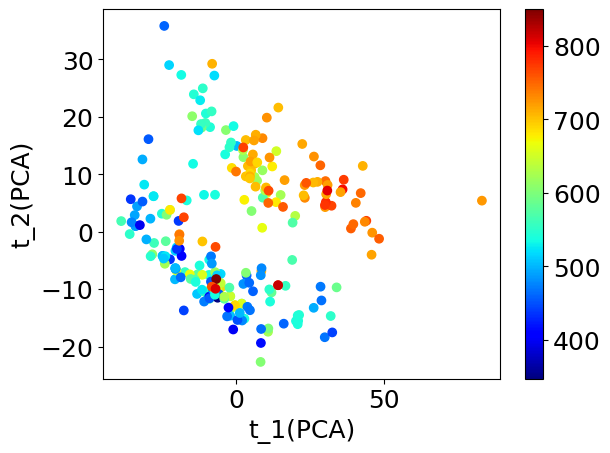

In [88]:
# 第一主成分と第二主成分の散布図
plt.scatter(score.iloc[:, 0], score.iloc[:, 1], c=y, cmap=plt.get_cmap('jet'))
plt.colorbar()

plt.xlabel('t_1(PCA)')
plt.ylabel('t_2(PCA)')

plt.show()

- 主成分空間において、目的変数が連続的に変化している⇒主成分スコア(PC1, PC2)を使うことで目的変数をある程度予測できそう
- PCA+回帰(PLS)での精度に期待ができる

## t-SNE

In [89]:
def k3n_error(x_1, x_2, k):
    """
    k-nearest neighbor normalized error (k3n-error)

    金子先生の手法、可視化する前のサンプル間のユークリッド距離と、可視化後のサンプル間のユークリッド距離に基づく方法

    サンプルの近接関係は多次元空間⇔2次元平面で保持されているか？ということで、細かく分けると、

    1. 多次元空間において近いサンプル同士は、2次元平面においても近いか？
    2. 2次元平面において近いサンプル同士は、多次元空間においても近いか？

    k3n_errorは1と2を同時に評価する、2つとも近ければよい。
    サンプル同士が近いほど、k3n_errorは小さくなる

    k3n-error = k3n-Z-error + k3n-X-error

    Parameters
    ----------
    x_1: numpy.array or pandas.DataFrame
    x_2: numpy.array or pandas.DataFrame
    k: int
        The numbers of neighbor

    Returns
    -------
    k3n_error : float
        k3n-Z-error or k3n-X-error
    """
    x_1 = np.array(x_1)
    x_2 = np.array(x_2)

    x_1_distance = cdist(x_1, x_1)
    x_1_sorted_indexes = np.argsort(x_1_distance, axis=1)
    x_2_distance = cdist(x_2, x_2)

    for i in range(x_2.shape[0]):
        _replace_zero_with_the_smallest_positive_values(x_2_distance[i, :])

    identity_matrix = np.eye(len(x_1_distance), dtype=bool)
    knn_distance_in_x_1 = np.sort(x_2_distance[:, x_1_sorted_indexes[:, 1:k + 1]][identity_matrix])
    knn_distance_in_x_2 = np.sort(x_2_distance)[:, 1:k + 1]

    sum_k3n_error = (
            (knn_distance_in_x_1 - knn_distance_in_x_2) / knn_distance_in_x_2
    ).sum()
    return sum_k3n_error / x_1.shape[0] / k

def _replace_zero_with_the_smallest_positive_values(arr):
    """
    Replace zeros in array with the smallest positive values.

    Parameters
    ----------
    arr: numpy.array
    """
    arr[arr == 0] = np.min(arr[arr != 0])

t-SNE の perplexity は「近傍とみなす範囲」を決める重要なハイパーパラメータであり：

- 小さすぎる → 局所構造に過剰適応し、過学習的
- 大きすぎる → グローバル構造を優先しすぎて局所が潰れる

k3n-errorが最小になるperplexityを選ぶことで、局所・大域構造のバランスが取れた可視化を得る

In [90]:
# k(近傍数)の数をサンプル数に応じて決定
n_samples = autoscaled_X.shape[0]
k_in_k3n_error = min(30, max(5, int(np.sqrt(n_samples))))  # 5〜30の範囲に制限

# perplexityの候補
candidates_of_perplexity = np.arange(5, 105, 5, dtype=int)

# k3n-errorを用いたperplexityの最適化
k3n_errors = []

for index, perplexity in enumerate(candidates_of_perplexity):
    # print(index + 1, '/', len(candidates_of_perplexity))

    # tsneの実行
    t = TSNE(perplexity=perplexity, n_components=2, init='pca', random_state=10).fit_transform(autoscaled_X)
    # tを標準化している
    scaled_t = (t-t.mean()) / t.std(axis=0, ddof=1)

    k3n_errors.append(k3n_error(autoscaled_X, scaled_t, k_in_k3n_error) + \
                      k3n_error(scaled_t, autoscaled_X, k_in_k3n_error))

# 最適な値を抽出
optimal_perplexity = candidates_of_perplexity[np.where(k3n_errors == np.min(k3n_errors))[0][0]]

print(f"使用するk（近傍数）: {k_in_k3n_error}")
print(f"最適なperplexity: {optimal_perplexity}")

使用するk（近傍数）: 15
最適なperplexity: 65


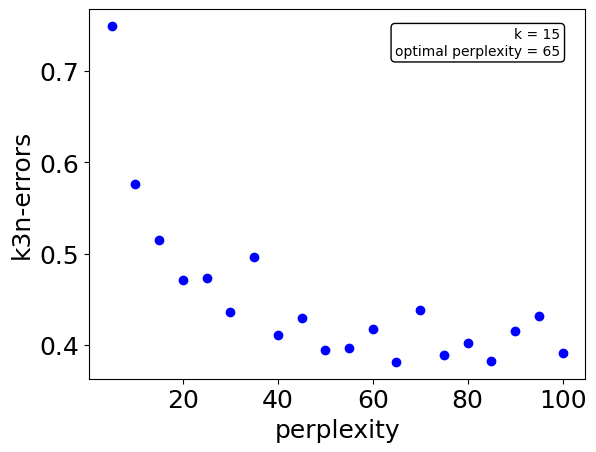

In [91]:
# 可視化
plt.scatter(candidates_of_perplexity, k3n_errors, c='blue')

# 右上に注釈を追加（位置は yのmax にちょっと足したくらい）
text_str = f'k = {k_in_k3n_error}\noptimal perplexity = {optimal_perplexity}'
plt.text(0.95, 0.95, text_str,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.xlabel('perplexity')
plt.ylabel('k3n-errors')
plt.show()

k3n-errorによるperplexityの最適解： 65


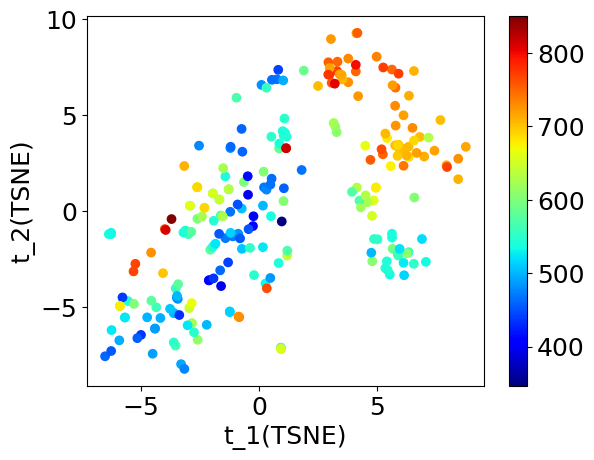

In [92]:
# 最適な値を抽出
optimal_perplexity = candidates_of_perplexity[np.where(k3n_errors == np.min(k3n_errors))[0][0]]
print('k3n-errorによるperplexityの最適解：', optimal_perplexity)

# t-SNE
t = TSNE(perplexity=optimal_perplexity, n_components=2,
         init='pca', random_state=10).fit_transform(autoscaled_X)

t = pd.DataFrame(t, index=X.index, columns=['t_1', 't_2'])

# t1とt2の散布図
plt.rcParams['font.size'] = 18
plt.scatter(t.iloc[:, 0], t.iloc[:, 1], c=y, cmap=plt.get_cmap('jet'))
plt.colorbar()

plt.xlabel('t_1(TSNE)')
plt.ylabel('t_2(TSNE)')
plt.show()

- t-SNE空間で近い⇒元の特徴空間でも似ている⇒yも似ている可能性あり